In [1946]:
#each loop produces delta functions for the signs of omegas
#remember we must also rack external omegas generated by the resolution of momenta
#colour the edges for quasimasses, i think that is enough to solve all omega-integrals - simpy plug in values on the basis of colours

# Integrals by sub

In [1]:
from sympy import *
import operator
import functools
init_printing()
#init_printing(use_latex='mathjax')

In [1948]:
#todo see how to use DiracDelta etc. in sympy for now i just want to be explicit
#https://docs.sympy.org/latest/modules/functions/special.html

class delta_constraint(object):
    def __init__(self, names):
        self._exp = functools.reduce(operator.add, [Symbol(n) for n in names] , 0)
        self._rep = Function("delta")(self._exp)
        
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self): return latex(self._rep,  mode='inline')
    def __call__(self, i):
        return solve(self._exp, Symbol("alpha"+"_"+(str(i))))[0]
    
class ddelta(object):
    def __init__(self, name, vec):
        self._name = name
        self._d = Symbol("delta")
        self._vec = symbols(" ".join([name+"_"+str(abs(v)) for v in range(len(vec))]))
        signed = lambda v : [vec[i] * self._vec[i] for i in range(len(vec))]
        self._signed = signed(self._vec)
        self._exp = functools.reduce(operator.add, self._signed, 0)
        self._rep = Function("delta")(self._exp)
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self): return latex(self._rep,  mode='inline')
    def __call__(self, i):
        return solve(self._exp, Symbol(self._name+"_"+(str(i))))[0]
    
    @property
    def value(self):return self._rep
        
    def substitution(self, i):
        term = self._signed[i]
        return {term :self(i)}
    
    
class explicit_ddelta(object):
    def __init__(self, key, val_list):
        self._exp = functools.reduce(operator.add, [key] + val_list , 0)
        self._rep = Function("delta")(self._exp)
        
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self): return latex(self._rep,  mode='inline')
    def __call__(self, i):
        return solve(self._exp, Symbol("alpha"+"_"+(str(i))))[0]
        
    
class signed_delta(explicit_ddelta):
    def __init__(self,name,index):
        explicit_ddelta.__init__(self,key=Symbol(name+"_"+str(index)+"^+"), val_list=[Symbol(name+"_"+str(index)+"^-")])
    
ddelta("alpha", [1,-1,-1]).substitution(0)
#explicit_ddelta(key=Symbol("omega_0^+"), val_list=[Symbol("omega_0^-")])
#signed_delta("omega",0)._rep

In [1949]:
delta_constraint(["a_1", "a_2", "f_9"])

$\delta{\left (a_{1} + a_{2} + f_{9} \right )}$

In [1950]:
import numpy as np
class __coeff__(object):
    def __init__(self, omegas=[-1*I], Dks=[[1]], ms=[1]):
        self._o = np.array(omegas)
        self._dk = np.array(Dks)
        self._m = ms

def sum_terms(name, coeff,use_letters=False):
    labels = [str(i) for i in range(len(coeff))] if not use_letters else ["a","b","c","d","e"]
    
    return [v* Symbol(name+"_"+labels[i]) for i, v in enumerate(coeff) ]

sum_terms("omega^+", [-1,1,-1])

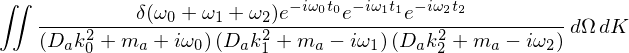

In [1951]:
def _sum_(terms): return functools.reduce(operator.add, terms , 0)

#def _double_sum_ops(names, tensor): _sum(names[0], _sum_(names[1], [for t in tensor])

class _scalar_propagator_(object):
    #coeff = for known species vector space, loop im
    def __init__(self,  index=0, coeff=__coeff__(), sense=-1, power=1):
        self._index = index
        self._power = power
        self._coeff = coeff
        self._sense = sense #topology
         
        _ks = [(_sum_(sum_terms("k", t)))**2 for t in self._coeff._dk]
        
        sense_term = "omega^+" if sense == 1 else "omega^-"
        sense_term = "omega"
        
        self._den = (_sum_(sum_terms(sense_term,self._coeff._o))
                       +_sum_(sum_terms("m",self._coeff._m,use_letters=True))
                       +_sum_(sum_terms("D",_ks,use_letters=True))
                       )
        self._value = self._den**(-1) 
        
        self._associated_delta_functions = [signed_delta("omega",index)._rep,signed_delta("k",index)._rep]

    @property
    def value(self):
        
        ret = self._value * functools.reduce(operator.mul, self._associated_delta_functions , 1)
        
        return ret.simplify()
        
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self): return latex(self.value,  mode='inline')
    def __call__(self, i):pass
    
    def subs(self, d):
        #as below for deltas, we need to keep track of terms seperately to avoid rediscovery, which needs cleaning up
        self._den = self._den.subs(d)
        self._value = self._value.subs(d)
        return self
    
    def apply_delta(self, d,i):
        #hacky - I have not thought out how these workflows should be done yet but I will
        self._den = self._den.subs(d.substitution(i))
        self._value = self._value.subs(d.substitution(i))
        
        return self
    
    def apply_delta_functions(self):
        #hack
        self._associated_delta_functions = []
        if self._sense == 1: 
            self._value=self._value.subs({"omega_"+str(self._index): -1*Symbol("omega_"+str(self._index)) })
            #hack see above
            self._den = self._den.subs({"omega_"+str(self._index): -1*Symbol("omega_"+str(self._index)) })
            
        return self
    
    def Ltransform(self):
        self._value = self._value #* exp(-I*Symbol("omega_"+str(self._index))*Symbol("t_"+str(self._index)))
        return self
    
    def Ftransform(self):
        self._value = self._value * exp(-I*Symbol("omega_"+str(self._index))*Symbol("t_"+str(self._index)))
        return self
    
def __prod__(l): return functools.reduce(operator.mul, l,1)
    
from IPython.display import Latex

class _integral_(object):
    def __init__(self, propagators, delta_funcs = [], dims=0):
        #d,k,o,p = symbols ("d k omega pi")
        #self.m = __prod__([ d*o/(2*p) for i in range(dims)]) * __prod__([ d*k**d/(2*Symbol("pi")**d) for i in range(dims)])
        self._propagators = [p for p in propagators]
        self._delta_funcs = [d for d in delta_funcs]
        
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self): 
        #init_printing(use_latex='mathjax')
        return latex(__prod__(self._propagators))
    #is it algorithmically quivalent to treat a multiple pole as two seperate poles?
    # no because that produces singular
    def find_zeros(self, sym, as_delta_functions=False):
        pass
    
    def subs(self,d):
        for d in self._delta_funcs: self._propagators = [p.subs(d) for p in self._propagators]
        return self
    
    def apply_deltas(self, i):
        for d in self._delta_funcs:
            self._propagators = [p.apply_delta(d,i) for p in self._propagators]
        self._delta_funcs = []
        return self
    
    @property
    def integral(self):
        l = [p.value for p in self._propagators] + [d.value for d in self._delta_funcs]
        return Integral( __prod__(l) ,(Symbol("\Omega")),(Symbol("K")))


C1 = __coeff__(Dks=[[1,0,0]], omegas=[I,0,0])
C2 = __coeff__(Dks=[[0,1,0]], omegas=[0,I,0])
C3 = __coeff__(Dks=[[0,0,1]], omegas=[0,0,I])

P1 = _scalar_propagator_(index=0,coeff=C1,sense=-1).apply_delta_functions().Ftransform()
P2 = _scalar_propagator_(index=1,coeff=C2,sense=1).apply_delta_functions().Ftransform()
P3 = _scalar_propagator_(index=2,coeff=C3,sense=1).apply_delta_functions().Ftransform()

IG = _integral_([P1,P2,P3],[ddelta("omega", [1,1,1])]).integral
IG
#remember there are twice as many integrals for senses propagators and the delta functions and integrals cancel only half of them!!

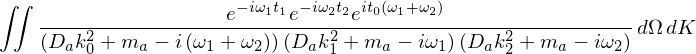

In [1952]:

IG = _integral_([P1,P2,P3],[ddelta("omega", [1,1,1])]).apply_deltas(0)
IG.integral

In [1953]:
def omega_solutions(IG, ofilter=None, isolate=False, evaluate=true):
    ofilter = "omega" if ofilter == None else ofilter
    #todo deal with multiple poles
    for expression in [P._den.expand() for P in IG._propagators]:
        for omega in [o for o in expression.as_ordered_terms() if ofilter in str(o)]:      
            #if omega is negative, maybe write in terms of positive but test workflow first
            factor = list(ter.as_coefficients_dict().values())[0] * I
            for sol in solve(expression, omega):
                res = {omega : sol.simplify()} if not isolate else { omega/factor : (sol/factor).simplify()}
                
                #if eval, identify f_hat as IG_prod / P._den
                
                #in reality we need to apply the contractions for each "loop" before continuing 
                #this is to say we iterate the integrals
                
                yield res
                
            
subit = list(omega_solutions(IG, "omega_1",isolate=True))[0]
subit
#P3.subs(subit)

In [1954]:
#figure out how to subclass express
G = -I * Symbol("omega_0")
str(G)

'-I*omega_0'

In [1955]:
class mom(Mul):
    def __new__(self, index=0):
        return Mul.__new__(self,  Symbol("k_"+(str(index)))**2)
               
class causal(Mul):
    def __new__(self, index=0,sign=-1):
        return Mul.__new__(self, sign* I * Symbol("omega_"+(str(index))))
        
class propagator(Mul):
    def __new__(self, i,sign=-1, a="a"):
        return Mul.__new__(self, 1/(causal(i,sign) +Symbol("D_"+a)* mom(i) + Symbol("m_"+a) ))

def __prod__(l): return functools.reduce(operator.mul, l,1)

def ftransform(var, to="t"):
    subscript = str(var).split("_")[-1]
    return exp(-I*var*Symbol(to+"_"+subscript))

class ddelta(object):
    def __init__(self, name, vec):
        self._name = name
        self._d = Symbol("delta")
        self._vec = symbols(" ".join([name+"_"+str(abs(v)) for v in range(len(vec))]))
        signed = lambda v : [vec[i] * self._vec[i] for i in range(len(vec))]
        self._signed = signed(self._vec)
        self._exp = functools.reduce(operator.add, self._signed, 0)
        self._rep = Function("delta")(self._exp)
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self): return latex(self._rep,  mode='inline')
    def __call__(self, i):
        return solve(self._exp, Symbol(self._name+"_"+(str(i))))[0]
    
    @property
    def value(self):return self._rep
        
    def substitution(self, i):
        term = self._signed[i]
        return {term :self(i)}

In [1956]:
ftransform(causal(0))

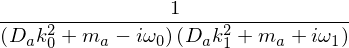

In [1957]:
propagator(0,-1)*propagator(1,1)

In [1958]:
#check my theory of integration
#i aut-fix contours for any one integration variable so as not to integrate both signs - but be careful that we have correct signs
#The iterated integrals dont interfer with resect to integration causal variables
#need to apply delta functions and transforms - the later is tricky because i need to track actual propagators
class propagator_inspector(object):
    def __init__(self, val):
        #temp I have some code that does this properly
        self._props = [1/p for p in val.as_numer_denom()[-1].as_ordered_factors()]
        self._d = {}
        self._var_set = []
        
        for prop in self._props:
            t = prop.as_powers_dict()
            base = list(t.keys())[0] 
            #for all omega variables in the propagator
            for omega in [t for t in base.expand().as_ordered_terms() if "omega" in str(t)]:
                eval_omega = omega.args[-1]
                self._var_set.append( eval_omega)
                sol = solve(base,eval_omega)[0]
                if eval_omega not in self._d: self._d[eval_omega] = {}
                #print("storing pole",str(eval_omega),"=",str(sol))
                #pole omega=sol
                self._d[eval_omega][sol] = {"base":base,  "value": prop,  "order": abs(list(t.values())[0]),  
                     "causal_variable":  eval_omega,
                                     #I think there is a better way to get this complex coefficient - must dig
                    "causal_sign" : omega.args[0] if len(omega.args)==3 else 1,
                    "quasimass" : sol #note i take the first solution of which i can prove there is one?
                            }

        self._var_set = set(self._var_set)
        
    def __getitem__(self,k): return self._d[k]
        
    def __iter__(self):  
        for p in self._props: yield p
    #make me a dictionary and return properties of any supplied propagator - allow power invariance??  
    
    #properties like pole order, zeroes, omega term, causal coefficient
    
class graph_integrand(object):
    def __init__(self, propagator_list, delta_functions = [], transforms=[]):       
        self._props = propagator_list if isinstance(propagator_list,list) else propagator_inspector(propagator_list)
        self._delta_functions = delta_functions      
        self._transforms = transforms      
        
        pi = propagator_inspector(self.value)
        self._omega_vars =  list(pi._var_set)
        
    @property
    def value(self):  
        deltas = __prod__([d.value for d in self._delta_functions])
        return __prod__(self._props) *deltas
    
    def integration_variables(self): return self._omega_vars

    def apply_delta_functions(self,i):
        _g = self
        for d in self._delta_functions:
            _g =  graph_integrand(self.value.subs(d.substitution(i)).simplify())
        return _g
    
    def __mul__(self,p): 
        newval = __prod__(self._props) * p
        #self._props = list(propagator_inspector(newval)) 
        return graph_integrand(list(propagator_inspector(newval)))
    
    def __truediv__(self,p): 
        newval = __prod__(self._props) / p
        #self._props = list(propagator_inspector(newval))
        return graph_integrand(list(propagator_inspector(newval)))
    
    def __call__(self, val, omega=None):
        omega = omega if omega != None else self._omega_vars[0]
        return self.value.subs({omega:val})
    
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self):  return latex(self.value,mode='inline')
     
    def factor(pole_structure):
    #usethe sign of the var and also the order of the pole
        return 1
    
    def poles_for(self, int_var=None):
        return list(graph_integrand.poles(self, int_var))
        
    def poles(intg,int_var=None):
        #for now I show the propagtors as the value
        pi = propagator_inspector(intg.value)

        def _gen_poles_(v): #poles where v=k
            fixed_contour = None
            poles_for_var = pi[v]
            for k,_p in poles_for_var.items():
                if fixed_contour == None: fixed_contour = _p["causal_sign"]
                #auto fix contout of integration for poles of this integration variable - dont mixed siges
                if _p["causal_variable"] == v and _p["causal_sign"] == fixed_contour: 
                    yield _p
                    
        keys = [int_var] if int_var != None else list(pi._d.keys())
        for k in keys:
            for p in _gen_poles_(k):
                yield p

    def D(self,order):
        return self#for now

    def residues(intg,v):
        for p in graph_integrand.poles(intg,v):
            #(n-1)th derivitive of f/P evaluated for the pole    
            g = (intg/p["value"]).D(p["order"]-1)
            val = factor(p) * g(p["quasimass"],v)
            #propagators simpification - may not work with transforms
            yield __prod__([p.simplify() for p in val.as_ordered_factors()])
            
    def integrate(intg,integration_vars=None):
        f = graph_integrand(intg.value)
        integration_vars = f._omega_vars if integration_vars == None else integration_vars
        for v in integration_vars:
            print("integrating", v)
            res = [r for r in graph_integrand.residues(f,v)]
            f = _sum_(res)
            f = graph_integrand(f)
        return f
    
    def _integrate_(self):return graph_integrand.integrate(self)
                

In [1959]:
IG = graph_integrand(prod([propagator(0,1),propagator(1,-1),propagator(2,-1)]), delta_functions=[ddelta("omega", [1,1,1])])
#IG = graph_integrand(prod([propagator(0,-1),propagator(0,1)]))
IG

$\frac{\delta{\left (\omega_{0} + \omega_{1} + \omega_{2} \right )}}{\left(D_{a} k_{0}^{2} + m_{a} + i \omega_{0}\right) \left(D_{a} k_{1}^{2} + m_{a} - i \omega_{1}\right) \left(D_{a} k_{2}^{2} + m_{a} - i \omega_{2}\right)}$

In [1960]:
#pi = propagator_inspector(IG.value)
#for k,v in pi[Symbol("omega_0")].items(): print(k,v)

In [1961]:
IGG = IG.apply_delta_functions(0)
IGG
#IGG.poles_for()

$\frac{1}{\left(D_{a} k_{0}^{2} + m_{a} - i \left(\omega_{1} + \omega_{2}\right)\right) \left(D_{a} k_{1}^{2} + m_{a} - i \omega_{1}\right) \left(D_{a} k_{2}^{2} + m_{a} - i \omega_{2}\right)}$

In [1963]:
#vb = IGG.integrate([Symbol("omega_1")]).value#.simplify()

In [1965]:
#vb = IGG.integrate().value#.simplify()

In [1966]:
vb.as_numer_denom()[-1].expand()

In [ ]:
# propagator manager should simplify these things as effectively simply terms with collected -iomega terms

## Now do loop integrals

In [ ]:
#To do this properly I need to implement the vertex delta functions with external momenta

In [1967]:
IG = graph_integrand(prod([propagator(0,1),propagator(0,-1),propagator(0,-1)]))
IG

$\frac{1}{\left(D_{a} k_{0}^{2} + m_{a} - i \omega_{0}\right)^{2} \left(D_{a} k_{0}^{2} + m_{a} + i \omega_{0}\right)}$

In [ ]:
IG.integrate()

# Enumerating and drawing diagram symmetries

In [2447]:
#need to find a way to better control arrow sizes and show on straight lines
#find independant cycles
#some cycle-based incidence matrix direction permutations
#generate system of equations from incident matrix

In [1785]:
#https://www.researchgate.net/profile/Roger_Sargent/publication/272481243_Tarjan-1973-_paper_used_in_TfCAPD_course/links/54e513d50cf276cec1731a86/Tarjan-1973-paper-used-in-TfCAPD-course.pdf?origin=publication_list
#https://stackoverflow.com/questions/25898100/enumerating-cycles-in-a-graph-using-tarjans-algorithm

#https://ieeexplore-ieee-org.iclibezp1.cc.ic.ac.uk/stamp/stamp.jsp?tp=&arnumber=1448962

In [1237]:
#treat trees like a Symbol(bin_str) using a a unique binary string for a tree
#we can define the full algebra on the rooted tree class and allow for expressions to be built once each terminal can be resolved
#hopefully we can expand the tree and keep the full AST for pretty printing
#pretty prinint needs to combine latex and SVG elements

# q-Labelling

# Accurate production of initial delta functions

# A generating function for delta functions

In [ ]:
#https://github.com/mathandy/svgpathtools